In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from lewidi_lib import (
    assign_cols_perf_metrics,
    enable_logging,
    join_correct_responses,
    load_preds,
    make_query_from_dict,
    process_rdf,
)
import pandas as pd

enable_logging()


ratings = pd.read_json(
    "../parquets/reasoning-ratings/template-2-reasoning-judge-responses.jsonl",
    lines=True,
)

metadata = {
    "template_id": 31,
    "model_id": "Qwen/Qwen3-32B",
    "gen_kwargs": "set2",
    "dataset": "CSC",
    "judge_model_id": "gemini-2.5-pro",
}

rdf = load_preds(parquets_dir="../parquets")


def preprocess(rdf: pd.DataFrame) -> pd.DataFrame:
    query = make_query_from_dict(metadata, rdf.columns)
    rdf = rdf.query(query)
    rdf = process_rdf(rdf)
    rdf = join_correct_responses(rdf)
    rdf = assign_cols_perf_metrics(rdf)
    return rdf


rdf = preprocess(rdf)

2025-06-18 20:16:11,384 - lewidi_lib - INFO - Starting processing with 1000 rows
2025-06-18 20:16:11,388 - lewidi_lib - INFO - Dropping 0 rows with success=False
2025-06-18 20:16:11,395 - lewidi_lib - INFO - Dropping 0 rows with col 'response' NA
2025-06-18 20:16:11,401 - lewidi_lib - INFO - Dropping 0 rows with empty response
2025-06-18 20:16:11,928 - lewidi_lib - INFO - Dropping 0 NA predictions


In [12]:
import json_repair
from lewidi_lib import drop_failed_rows, drop_na_response_rows
import numpy as np
from prm800k import extract_rating

ratings = drop_failed_rows(ratings)
ratings["step_ratings"] = (
    ratings["response"].apply(json_repair.loads).apply(extract_rating)
)
ratings = drop_na_response_rows(ratings, col="step_ratings")
ratings["avg_step_rating"] = ratings["step_ratings"].apply(np.mean)

2025-06-18 20:16:12,690 - lewidi_lib - INFO - Dropping 11 rows with success=False


2025-06-18 20:16:14,367 - prm800k - WARNING - Could not parse: [{'text': "\nOkay, let's tackle this problem.", 'rating': 'okay'}, {'text': 'So, the task is to guess the distribution of sarcasm ratings for the given response based on the context.', 'rating': 'great'}, {'text': 'The response is "i would just laugh" to a situation where Steve is wearing his shoes on his hands and says he\'s Mr. Shoehand.', 'rating': 'great'}, {'text': 'First, I need to understand what sarcasm means here.', 'rating': 'great'}, {'text': 'The definition provided is using remarks that mean the opposite to hurt or criticize humorously.', 'rating': 'great'}, {'text': "The response is someone saying they'd just laugh.", 'rating': 'okay'}, {'text': 'Now, is there any sarcasm in that?', 'rating': 'great'}, {'text': 'Well, the context is Steve being silly by putting shoes on his hands and making up a name.', 'rating': 'great'}, {'text': "The person responding says they'd laugh.", 'rating': 'okay'}, {'text': 'On the

In [13]:
join_cols = ["dataset", "dataset_idx", "run_idx"]  # expand when more cols!
ratings_cols = [
    "step_ratings",
    "avg_step_rating",
    "reasoning",
    "judge_model_id",
    "dataset",
    "dataset_idx",
    "run_idx",
]
joint = ratings[ratings_cols].merge(
    rdf, on=join_cols, how="inner", suffixes=("_judge", "")
)

In [74]:
joint[["avg_step_rating", "ws_loss"]].corr()

,avg_step_rating,ws_loss
avg_step_rating,1.000000,-0.190815
ws_loss,-0.190815,1.000000


##### example 8: too lax with spread out distribution
for k, v in (
    joint.iloc[37][
        ["text", "reasoning", "response", "target", "reasoning_judge", "response_judge"]
    ]
    .to_dict()
    .items()
):
    print(k, v)
    print("-" * 100)

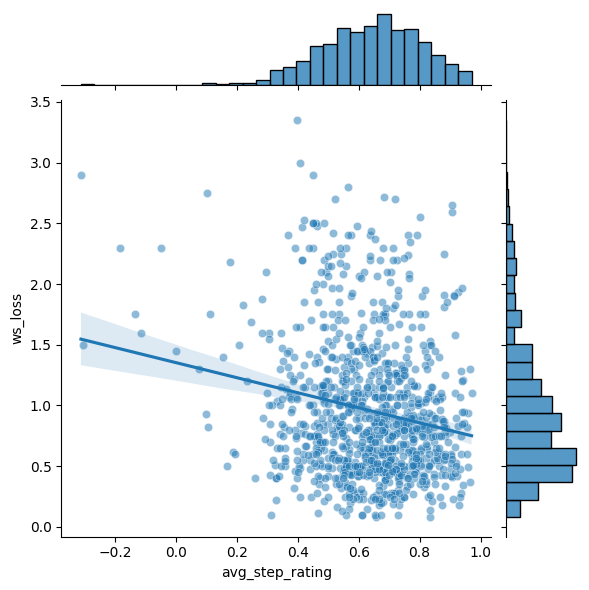

In [72]:
import seaborn as sns

# Using JointGrid directly for more control
fgrid = sns.JointGrid(data=joint, x="avg_step_rating", y="ws_loss")
fgrid.plot_joint(sns.scatterplot, alpha=0.5)
fgrid.plot_joint(sns.regplot, scatter=False)  # Add regression line
fgrid.plot_marginals(sns.histplot)

In [15]:
(joint.groupby("dataset_idx").size() == 10).all()

np.False_

In [16]:
rdflarge = load_preds("/mnt/disk16tb/globus_shared/from-lrz-ai-systems/")
rdflarge = preprocess(rdflarge)

2025-06-18 20:16:16,470 - lewidi_lib - INFO - Starting processing with 225120 rows
2025-06-18 20:16:16,588 - lewidi_lib - INFO - Dropping 2 rows with success=False
2025-06-18 20:16:17,127 - lewidi_lib - INFO - Dropping 0 rows with col 'response' NA
2025-06-18 20:16:17,235 - lewidi_lib - INFO - Dropping 0 rows with empty response
2025-06-18 20:16:21,643 - lewidi_lib - INFO - Dropping 28 NA predictions


In [17]:
# there is almost no performance difference between the normal outputs
# and those selected for top trace ratings
avg_ws_loss = rdflarge.groupby("dataset_idx", as_index=False).agg(
    ws_loss=("ws_loss", "mean"), pred_entropy=("pred_entropy", "mean")
)
avg_ws_loss.mean()

dataset_idx     3526.665068
ws_loss            1.008463
pred_entropy       1.377596
dtype: float64

In [18]:
best_by_judge = joint.loc[joint.groupby("dataset_idx")["avg_step_rating"].idxmax()][
    [
        "dataset_idx",
        "avg_step_rating",
        "tgt_has_holes",
        "ws_loss",
        "pred_entropy",
        "target_entropy",
    ]
]

In [19]:
from lewidi_lib import compute_average_baseline

model_avg_baseline = compute_average_baseline(rdflarge)

In [20]:
rdflarge = rdflarge.assign(
    entropy_rank=rdflarge.groupby("dataset_idx")["pred_entropy"]
    .rank(method="first")
    .astype(int)
)
by_entropy = rdflarge.groupby("entropy_rank", as_index=False)[
    ["ws_loss", "pred_entropy"]
].mean()
by_entropy["type"] = (
    "entropy"  # "entropy r" + (by_entropy["entropy_rank"] - 1).astype(str)
)
by_entropy.head(2)

,entropy_rank,ws_loss,pred_entropy,type
0,1,1.119862,0.938577,entropy
1,2,1.121321,0.938577,entropy


In [21]:
cols = ["pred_entropy", "ws_loss"]
loss_vs_entropy = pd.DataFrame(
    {
        "best_by_judge": best_by_judge[cols].mean(),
        "simple": avg_ws_loss[cols].mean(),
        "model_avg_baseline": model_avg_baseline[cols].mean(),
    }
).T.reset_index(names="type")
loss_vs_entropy = pd.concat([loss_vs_entropy, by_entropy.drop(columns="entropy_rank")])

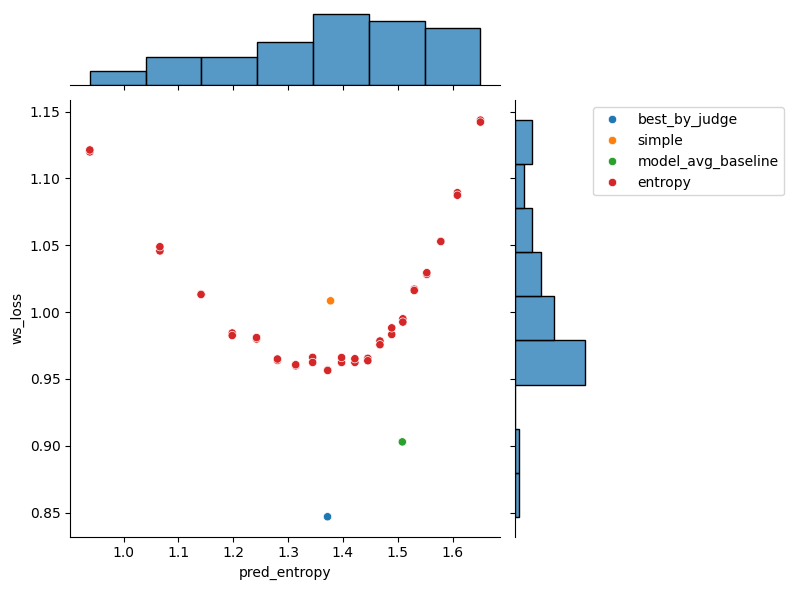

In [22]:
grid = sns.JointGrid(data=loss_vs_entropy, x="pred_entropy", y="ws_loss")
grid.plot_joint(sns.scatterplot, hue=loss_vs_entropy["type"])
grid.plot_marginals(sns.histplot, multiple="stack")
grid.ax_joint.legend(bbox_to_anchor=(1.2, 1), loc="upper left")

import matplotlib.pyplot as plt
import seaborn as sns

grid1 = sns.jointplot(data=model_avg_baseline, x="pred_entropy", y="ws_loss", marginal_kws={'bins': 20})
grid1.fig.suptitle("Model Avg Baseline", y=1.02)
ylim = (rdflarge["ws_loss"].min(), rdflarge["ws_loss"].max())
grid1.ax_joint.set_ylim(ylim)

grid2 = sns.jointplot(data=rdflarge, x="pred_entropy", y="ws_loss", marginal_kws={'bins': 20})
grid2.fig.suptitle("Simple", y=1.02)
grid1.ax_joint.set_ylim(ylim)

<Axes: xlabel='type', ylabel='ws_loss'>

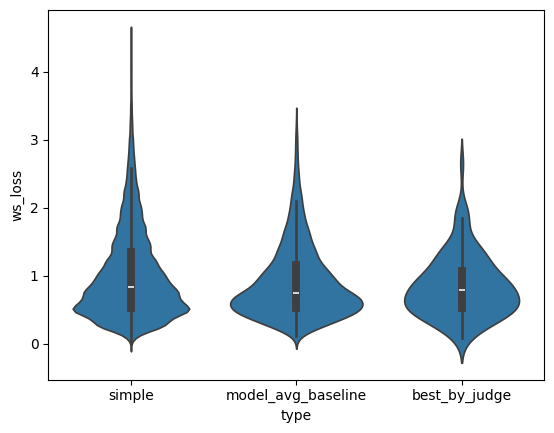

In [23]:
hist_data = pd.concat(
    [
        rdflarge.assign(type="simple"),
        model_avg_baseline.assign(type="model_avg_baseline"),
        best_by_judge.assign(type="best_by_judge"),
    ]
)

sns.violinplot(hist_data, x="type", y="ws_loss", common_norm=False)

# Tail of High Loss

In [24]:
best_by_judge.sort_values("ws_loss", ascending=False).head(3)

,dataset_idx,avg_step_rating,tgt_has_holes,ws_loss,pred_entropy,target_entropy
463,2907,0.906250,False,2.650000,1.565731,1.039721
246,6827,0.939394,False,1.970000,1.382820,1.039721
206,749,0.925926,True,1.933333,1.656947,1.242453


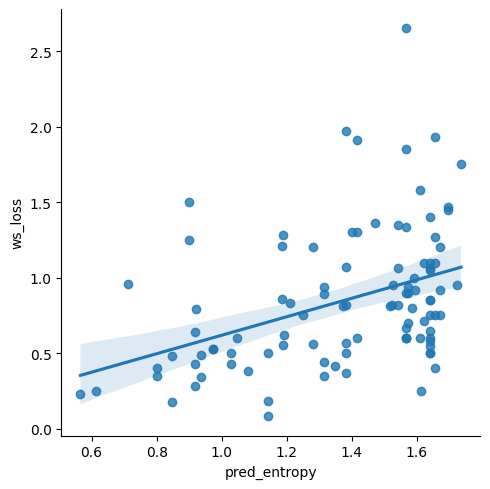

In [25]:
sns.lmplot(best_by_judge, x="pred_entropy", y="ws_loss")

<Axes: xlabel='avg_step_rating', ylabel='ws_loss'>

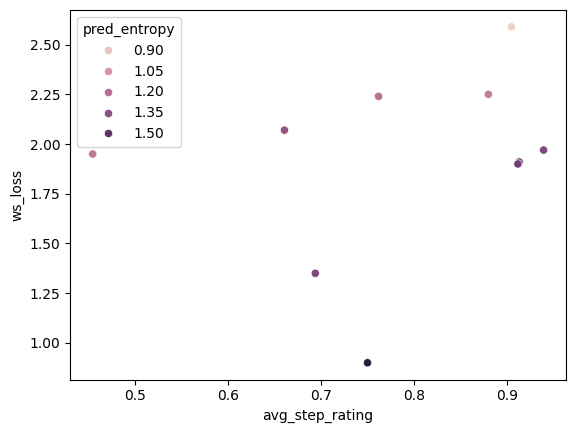

In [26]:
sns.scatterplot(
    joint.query("dataset_idx == 6827"),
    x="avg_step_rating",
    y="ws_loss",
    hue="pred_entropy",
)

In [27]:
max_ratings = joint.groupby("dataset_idx", as_index=False).agg(
    n_max_ratings=("avg_step_rating", lambda s: (s.max() == s).sum()),
    max_rating=("avg_step_rating", "max"),
    avg_pred_entropy=("pred_entropy", "mean"),
)

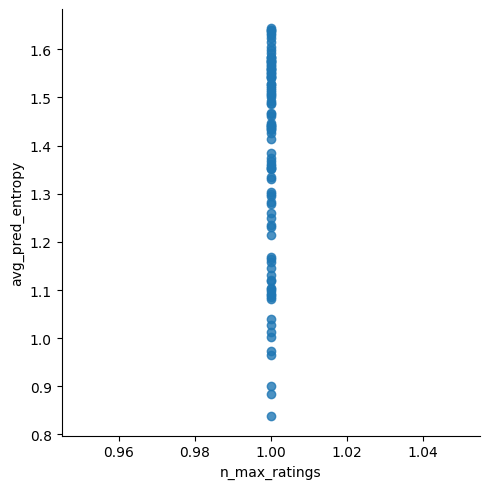

In [28]:
sns.lmplot(max_ratings.merge(best_by_judge), x="n_max_ratings", y="avg_pred_entropy")

# When does Model Averaging improve?

In [29]:
improvements = (
    rdflarge.groupby(["dataset_idx", "tgt_has_holes"], as_index=False)
    .agg(
        avg_ws_loss=("ws_loss", "mean"),
        avg_pred_entropy=("pred_entropy", "mean"),
    )
    .merge(model_avg_baseline[["dataset_idx", "ws_loss", "pred_entropy"]])
    .assign(improvement=lambda df: df["avg_ws_loss"] - df["ws_loss"])
    .assign(pred_entropy_diff=lambda df: df["pred_entropy"] - df["avg_pred_entropy"])
)

improvements.sort_values("improvement", ascending=False).head(3)

,dataset_idx,tgt_has_holes,avg_ws_loss,avg_pred_entropy,ws_loss,pred_entropy,improvement,pred_entropy_diff
346,439,True,1.189083,1.257816,0.474083,1.597061,0.715,0.339246
1669,2092,True,1.094500,1.423828,0.399500,1.756968,0.695,0.333140
2821,3556,True,1.112000,1.332408,0.430000,1.683678,0.682,0.351270


<Axes: xlabel='improvement', ylabel='pred_entropy_diff'>

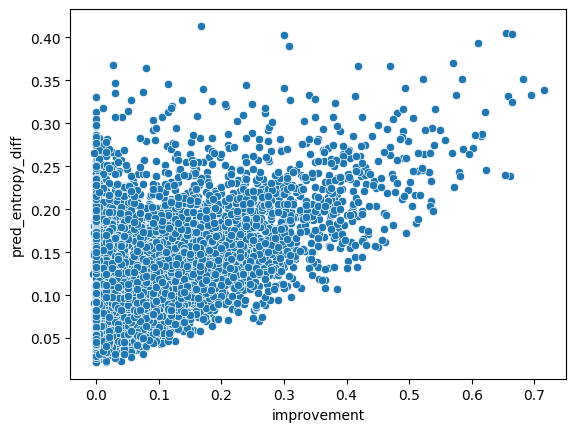

In [30]:
sns.scatterplot(
    improvements,
    x="improvement",
    y="pred_entropy_diff",
)

<Axes: xlabel='improvement', ylabel='Count'>

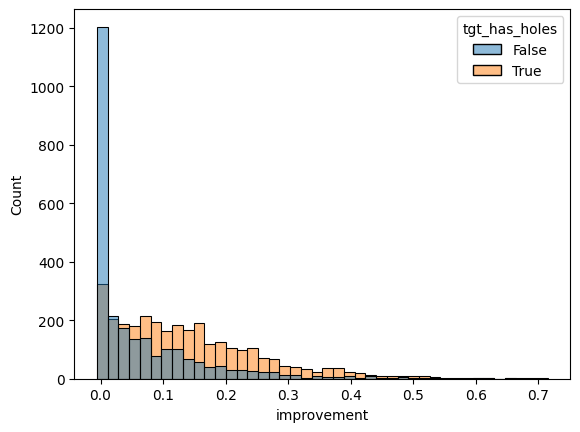

In [31]:
sns.histplot(improvements, x="improvement", hue="tgt_has_holes")

In [32]:
example = rdflarge.query("dataset_idx == 2092").sort_values("ws_loss")
example[["pred", "ws_loss"]].tail(5)

,pred,ws_loss
136494,"[0.0, 0.7, 0.2, 0.05, 0.03, 0.015, 0.005]",2.025
136480,"[0.0, 0.7, 0.2, 0.08, 0.01, 0.005, 0.005]",2.065
136500,"[0.0, 0.7, 0.2, 0.08, 0.01, 0.005, 0.005]",2.065
136490,"[0.0, 0.8, 0.15, 0.05, 0.0, 0.0, 0.0]",2.250
136470,"[0.0, 0.8, 0.15, 0.05, 0.0, 0.0, 0.0]",2.250


In [33]:
example["ws_loss"].mean()

np.float64(1.0945)

2025-06-18 20:16:29,869 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-18 20:16:29,873 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


0    0.3995
Name: ws_loss, dtype: float64


<Axes: >

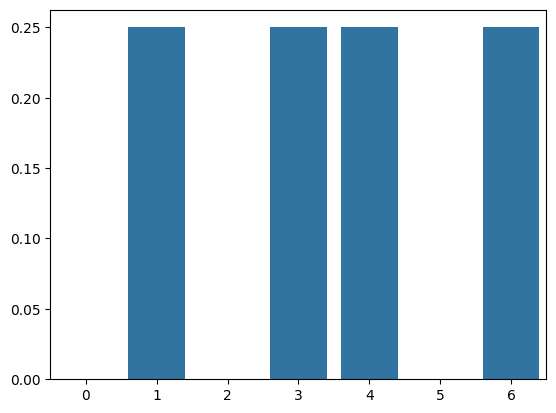

In [34]:
example_improved = compute_average_baseline(example)
print(example_improved["ws_loss"])
sns.barplot(example_improved["target"].iloc[0])